In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00


In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
df=pd.read_csv("international-airline-passengers.csv",header=None)

In [ ]:
df.columns=['year','passengers']

In [ ]:
df

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [ ]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
print("Time period starting range:",df.year.min())

Time period starting range: 1949-01


In [ ]:
print("Time period ending range :",df.year.max())

Time period ending range : 1960-12


In [ ]:
df

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [ ]:
df['year']=pd.to_datetime(df['year'],format='%Y-%m')

In [ ]:
df

,year,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [ ]:
#keeping the index as the datetime column

df2 = df.set_index('year')

In [ ]:
df2.isnull().sum()

# no null values present in our data

passengers    0
dtype: int64

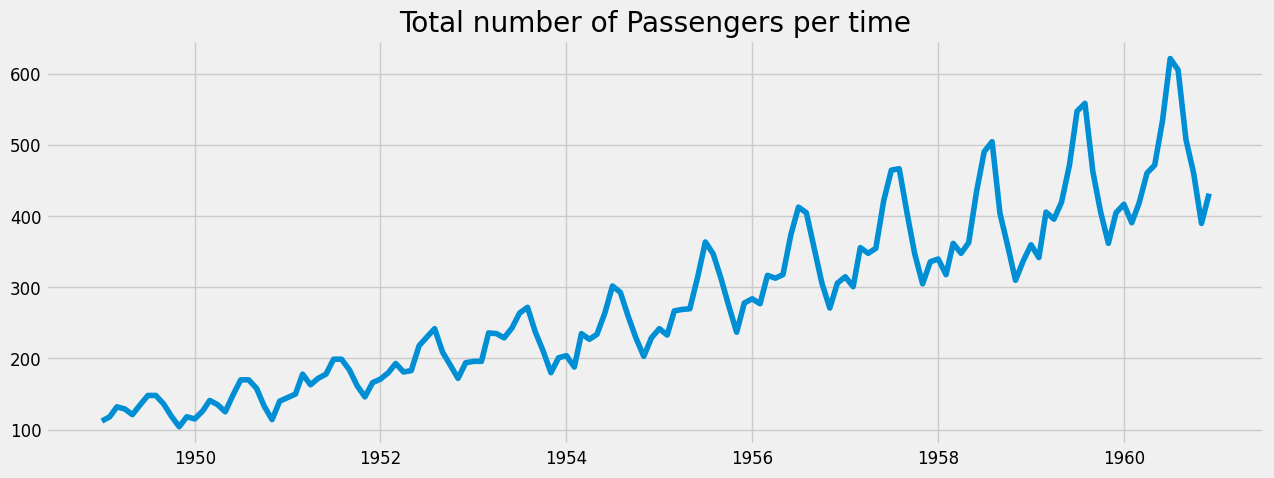

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df2)
plt.title("Total number of Passengers per time")
plt.show()

### COMMENT:

Here we can clearly see the data is not normally distributed and the distribution is left shifted. So we need to make the data stationary

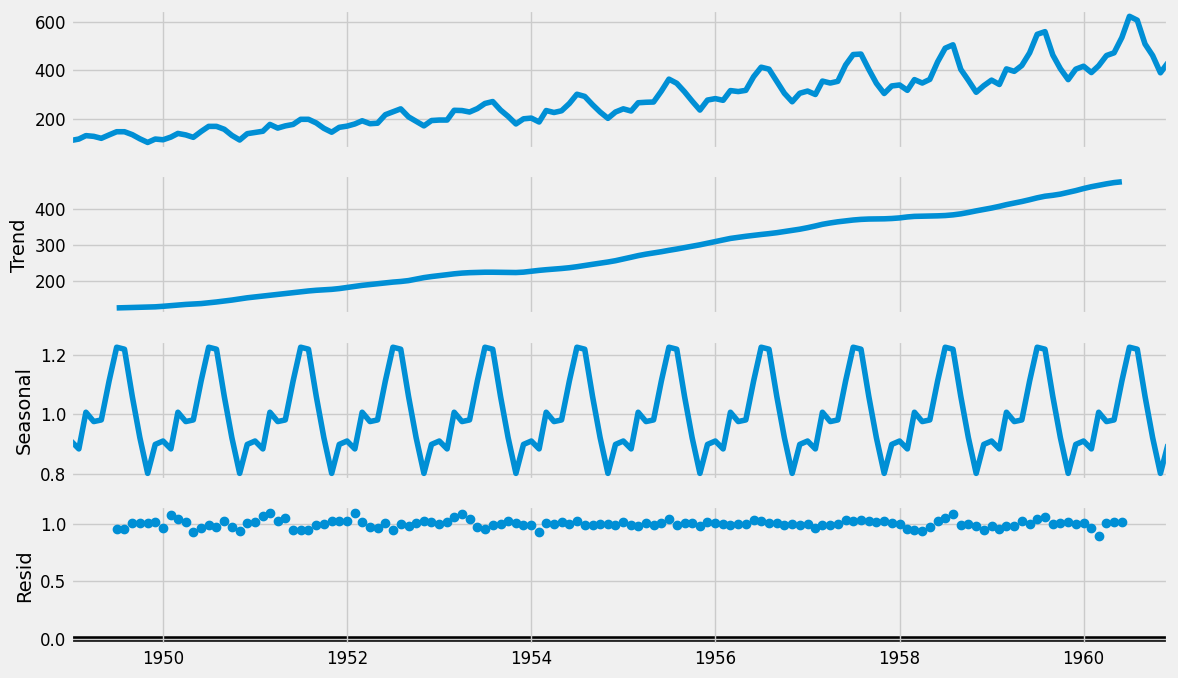

<Figure size 1400x1000 with 0 Axes>

In [ ]:
from pylab import rcParams
rcParams['figure.figsize']=12,7
residualcomponents = sm.tsa.seasonal_decompose(df2,model="multiplicative")
fig=residualcomponents.plot()
plt.figure(figsize=(14,10))
plt.show()

### Comment :
we can see the upward trend

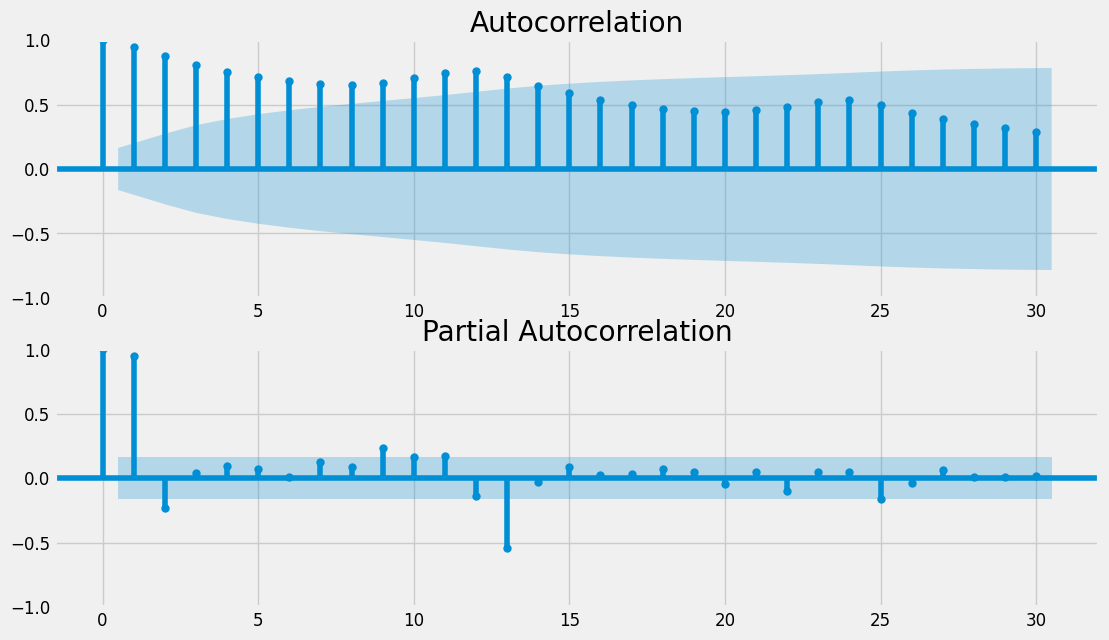

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(df2.passengers,ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(df2.passengers,ax=plt.gca(),lags=30)
plt.show()

# Function for plotting rolling stats & perform Dickey-Fuller test

In [ ]:
def stationary_check(timeseries):

    #Getting rolling stats
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()

    #Plotting the rolling stats
    original = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    std_dev = plt.plot(rolling_std, color='red', label = 'Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.figure(figsize=(13,5))
    plt.show()

    #Performing the Dickey-Fuller test
    print('Dickey-Fuller Test Result:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags','#Observations'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)

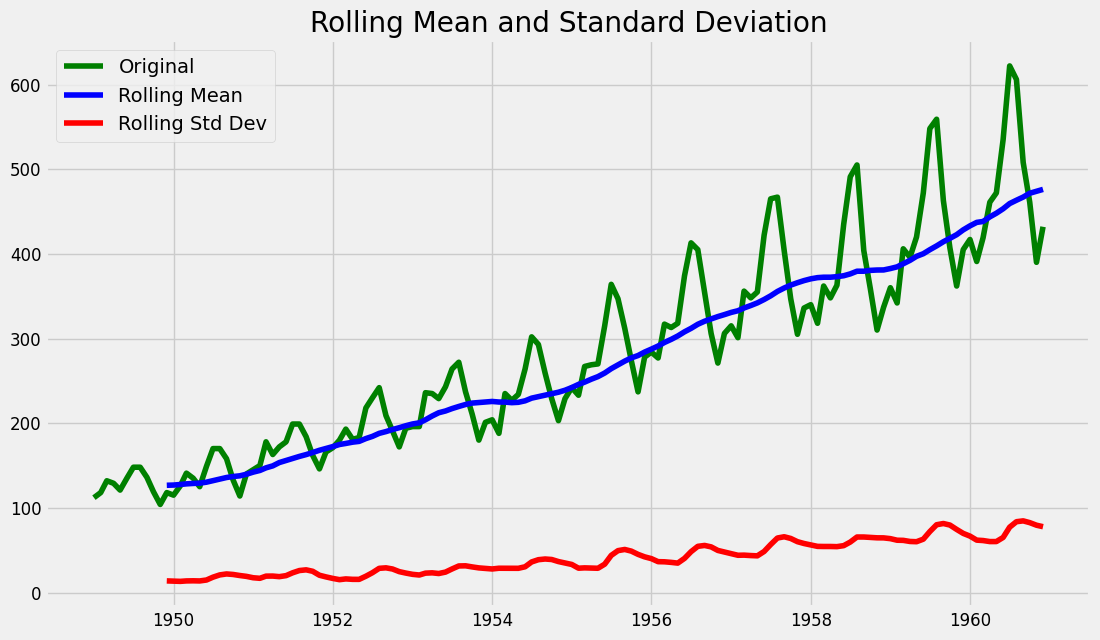

<Figure size 1300x500 with 0 Axes>

Dickey-Fuller Test Result:
Test Statistic            0.815369
p-value                   0.991880
#Lags                    13.000000
#Observations           130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [ ]:
stationary_check(df2)

### Comment :

Here we can clearly see that the rolling mean and rolling standard deviation have an increasing trend and are not constant with respect to time.

Hence the data is not stationary.

# Steps to make time series stationary
Trend and Seasonality are the factors for non-stationurity of a time series. For example, On average, the number of passengers is increasing over time which indicates trend.

To remove trend, we can apply transformations like log transformation. Taking a log transform here for simplicity:

Text(0.5, 1.0, 'Log Scale Transformation')

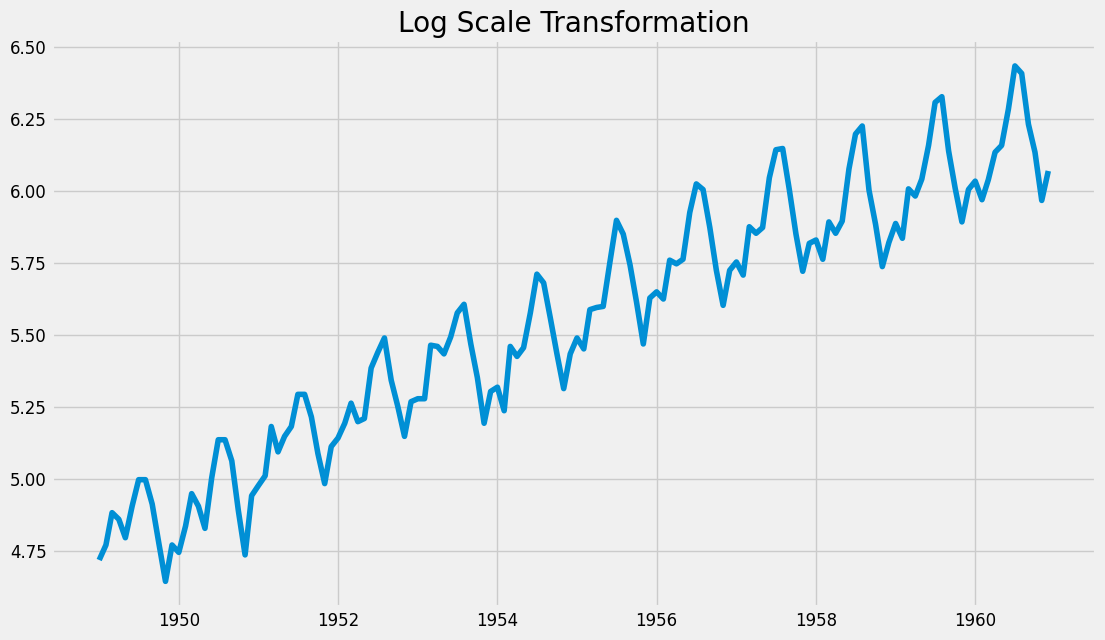

In [ ]:
#log scale transormation

ts_log_scale = np.log(df2)
plt.plot(ts_log_scale)
plt.title("Log Scale Transformation")

# Using smoothing to remove Trend in our Dataset

##### Moving Average for smoothing

Text(0.5, 1.0, 'Moving Avg for smoothing')

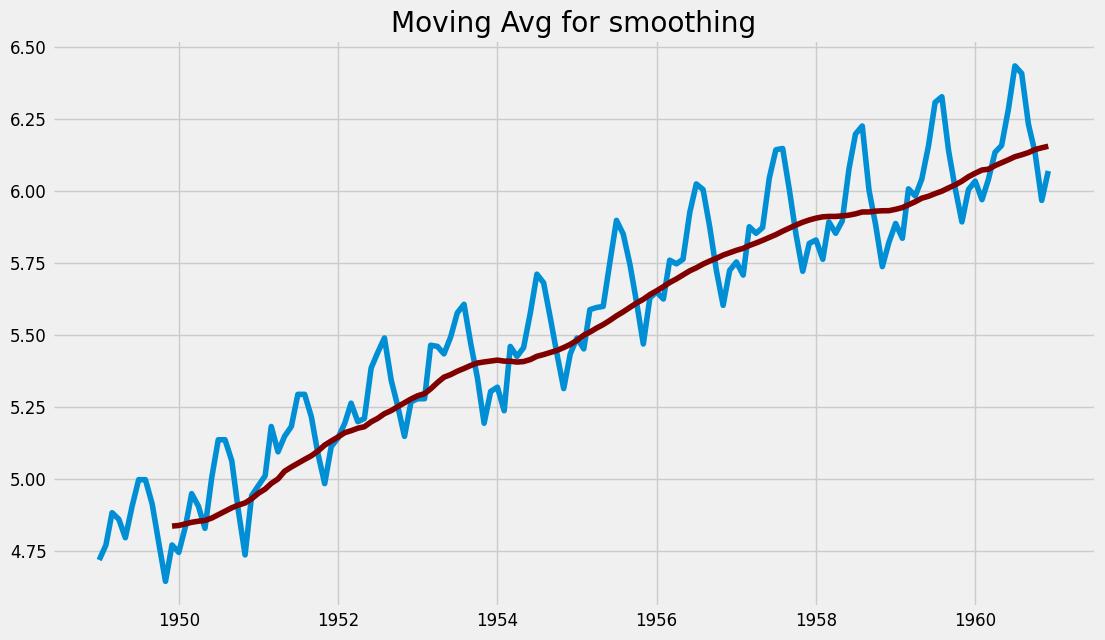

In [ ]:
mov_avg = ts_log_scale.rolling(12).mean()
plt.plot(ts_log_scale)
plt.plot(mov_avg, color='maroon')
plt.title("Moving Avg for smoothing")

In [ ]:
# Taking difference to remove trend
ts_log_scale_mov_avg_diff = ts_log_scale.passengers - mov_avg.passengers
ts_log_scale_mov_avg_diff.head(12)
# Dropping null values
ts_log_scale_mov_avg_diff = ts_log_scale_mov_avg_diff.dropna()

#### Plotting rolling stats and performing stationary check for moving avg difference data

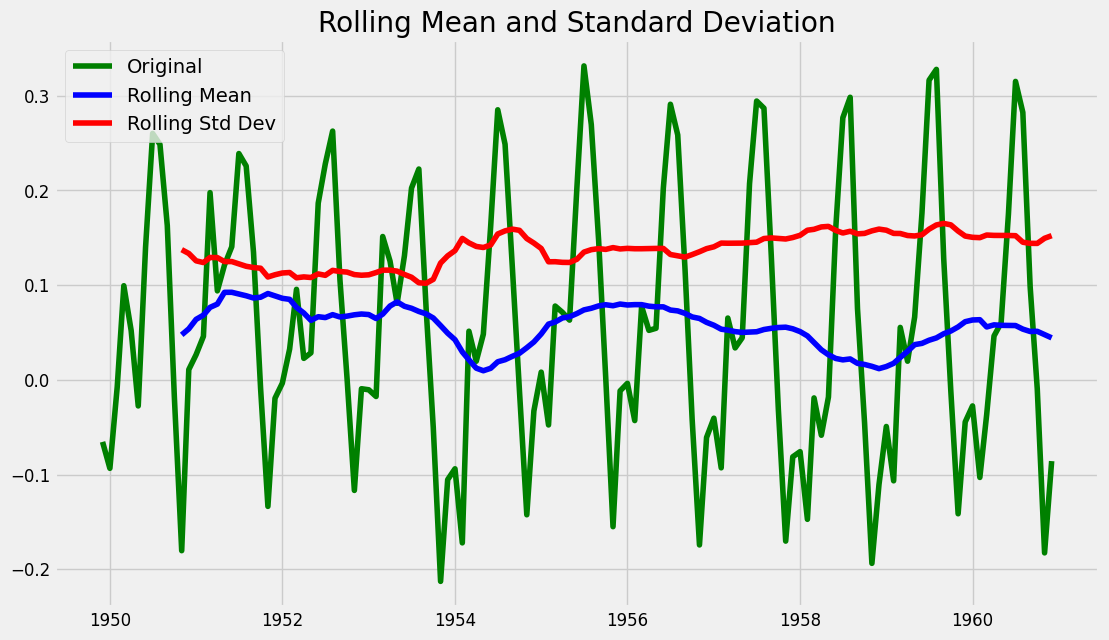

<Figure size 1300x500 with 0 Axes>

Dickey-Fuller Test Result:
Test Statistic           -3.162908
p-value                   0.022235
#Lags                    13.000000
#Observations           119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [ ]:
# Calling the stationary check function
stationary_check(ts_log_scale_mov_avg_diff)

#### Performing Differencing

Text(0.5, 1.0, 'Differencing to remove trend and seasonality')

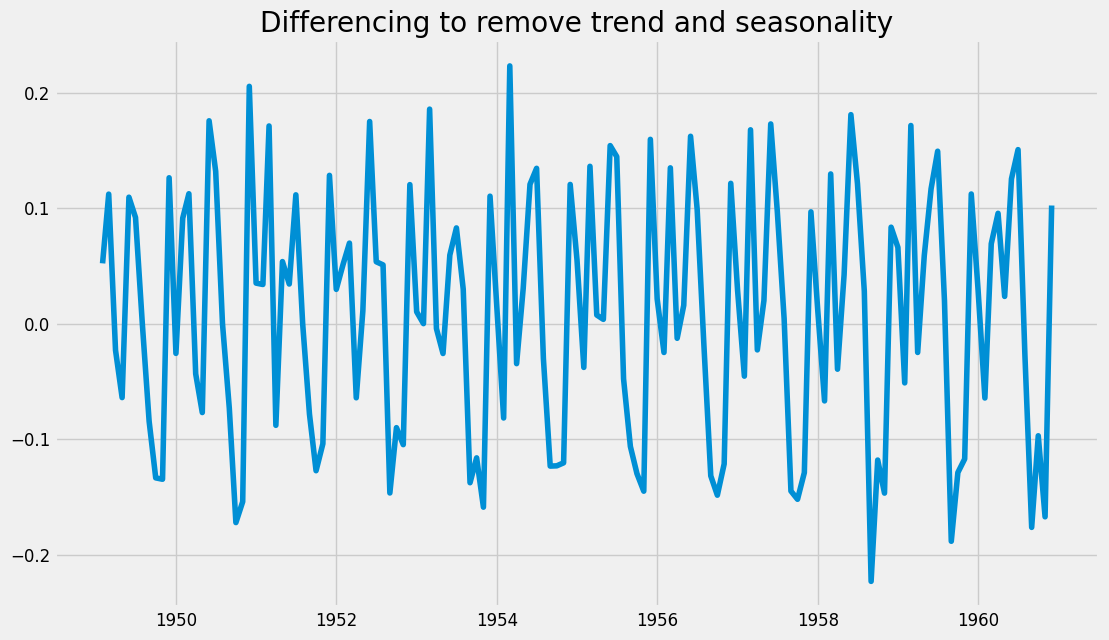

In [ ]:
ts_log_scale_diff = ts_log_scale.passengers - ts_log_scale.passengers.shift()
plt.plot(ts_log_scale_diff)
plt.title("Differencing to remove trend and seasonality")

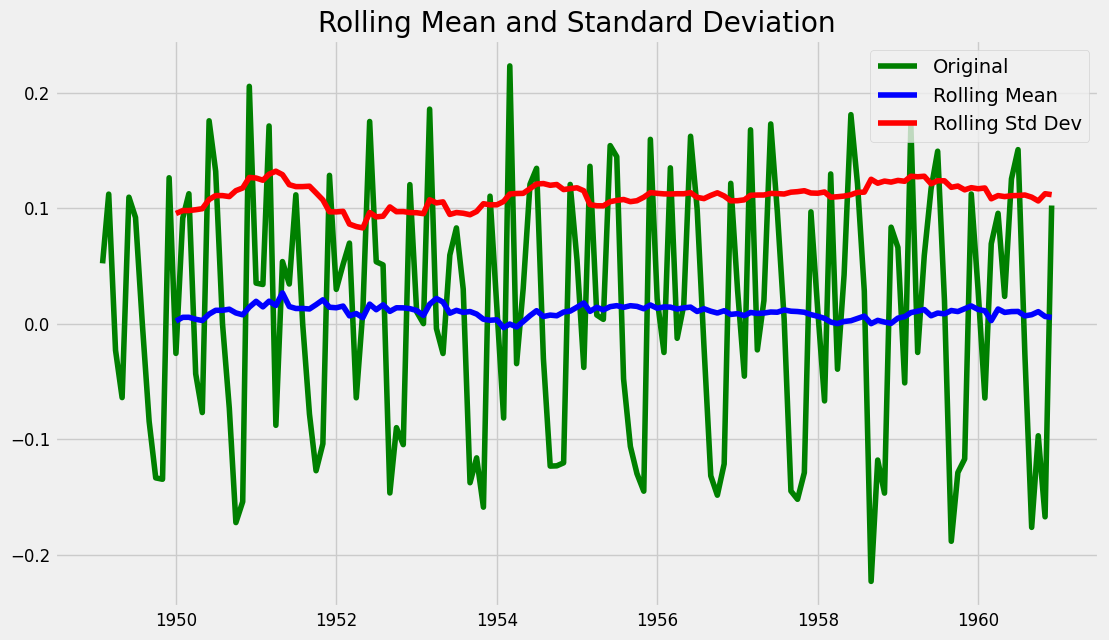

<Figure size 1300x500 with 0 Axes>

Dickey-Fuller Test Result:
Test Statistic           -2.717131
p-value                   0.071121
#Lags                    14.000000
#Observations           128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [ ]:
ts_log_scale_diff.dropna(inplace=True)
stationary_check(ts_log_scale_diff)

#### Performing Decomposition
- We are performing decomposition, in this approach both trend and seasonality are modelled separately & remaining part of the series is returned

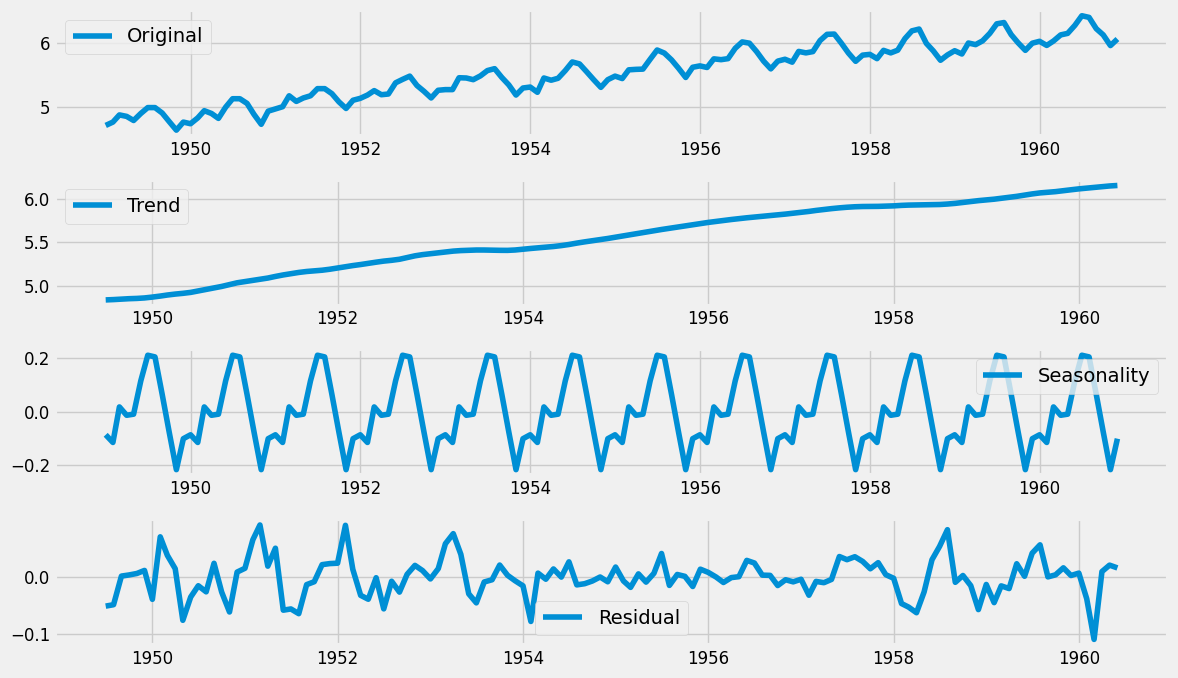

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_scale)

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_scale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.columns=["year","passengers"]

residual=residual.reset_index(name="passengers")


In [ ]:
residual=residual.dropna()

In [ ]:
ts_log_decomp = residual.passengers

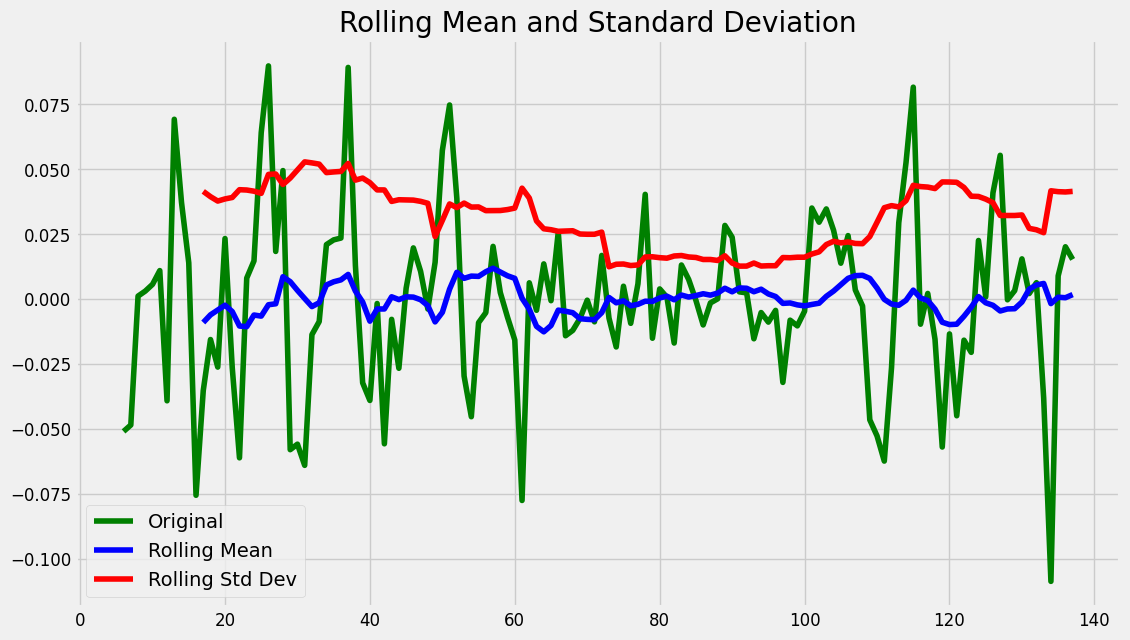

<Figure size 1300x500 with 0 Axes>

Dickey-Fuller Test Result:
Test Statistic         -6.332387e+00
p-value                 2.885059e-08
#Lags                   9.000000e+00
#Observations           1.220000e+02
Critical Value (1%)    -3.485122e+00
Critical Value (5%)    -2.885538e+00
Critical Value (10%)   -2.579569e+00
dtype: float64


In [ ]:
stationary_check(ts_log_decomp)

# Time Series Forecasting Models

#### Autoregression

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

In [ ]:
# model fitting
ar_model = AutoReg(ts_log_scale_diff,lags=15)
model_fit = ar_model.fit()

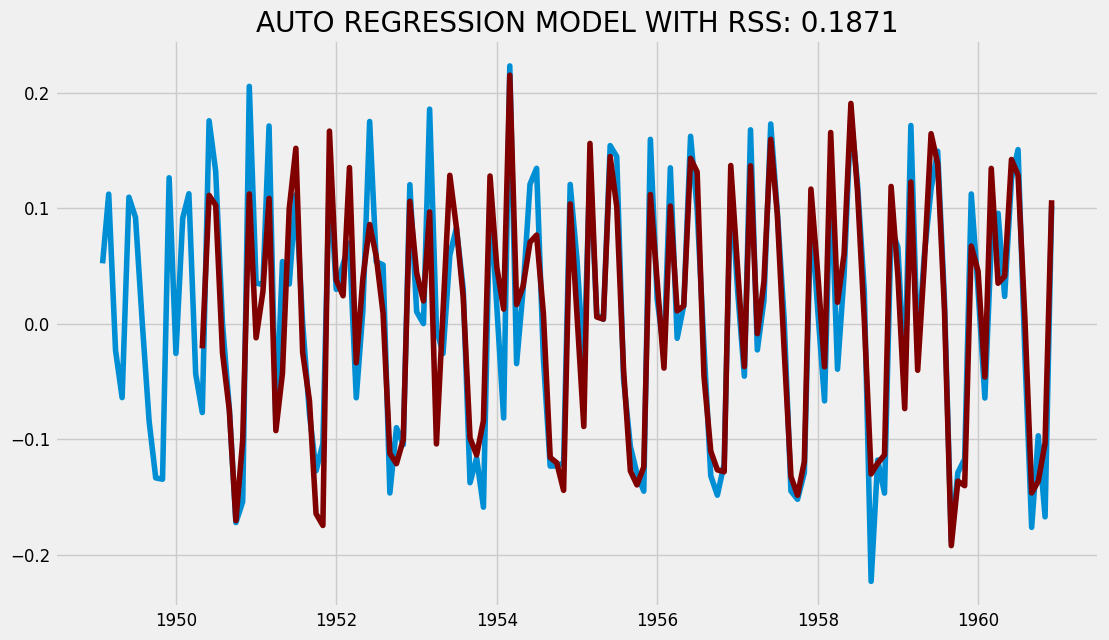

In [ ]:
plt.plot(ts_log_scale_diff)
plt.plot(model_fit.fittedvalues, color='maroon')
plt.title('AUTO REGRESSION MODEL WITH RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_scale_diff)**2))
plt.show()

In [ ]:
predictions_ARIMA_diff_value = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff_value.head())

# Cumulative calculation

predictions_ARIMA_diff_cumsum_value = predictions_ARIMA_diff_value.cumsum()
print (predictions_ARIMA_diff_cumsum_value.head())

# Adding first month value back
predictions_ARIMA_log_scale = pd.Series(ts_log_scale.passengers.iloc[0], index=ts_log_scale.index)
predictions_ARIMA_log_scale = predictions_ARIMA_log_scale.add(predictions_ARIMA_diff_cumsum_value,fill_value=0)
predictions_ARIMA_log_scale.head()

year
1950-05-01   -0.021379
1950-06-01    0.111066
1950-07-01    0.102570
1950-08-01   -0.025265
1950-09-01   -0.074791
dtype: float64
year
1950-05-01   -0.021379
1950-06-01    0.089687
1950-07-01    0.192258
1950-08-01    0.166993
1950-09-01    0.092202
dtype: float64


year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [ ]:
predictions_ARIMA_value = np.exp(predictions_ARIMA_log_scale)

Text(0.5, 1.0, 'RMSE AFTER TAKING EXPONENT: 93.6068')

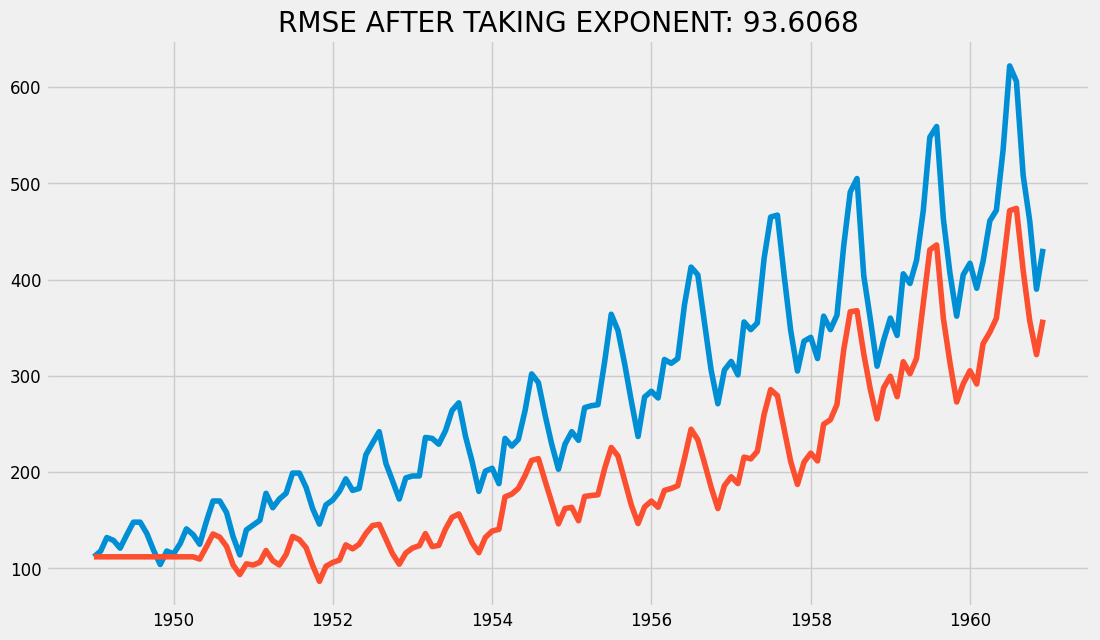

In [ ]:
plt.plot(df2.passengers)
plt.plot(predictions_ARIMA_value)
plt.title('RMSE AFTER TAKING EXPONENT: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_value-df2.passengers)**2)/len(df2.passengers)))

# Metrics to evaluate model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

r2_score=r2_score(df2.passengers, predictions_ARIMA_value)

mean_squared_error=mean_squared_error(df2.passengers, predictions_ARIMA_value)

In [ ]:
print("The value of r2 is:",r2_score)
print("The value of MSE is:",mean_squared_error)

The value of r2 is: 0.3869122415923706
The value of MSE is: 8762.233892972294


# Moving Average

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random

# Assuming ts_log_scale_diff is your differenced time series data
# Fit model as an ARMA using the ARIMA class
model = ARIMA(ts_log_scale_diff, order=(0, 0, 1))  # ARIMA with d=0 is equivalent to ARMA
model_fit = model.fit()

Text(0.5, 1.0, 'MOVING AVERAGE WITH RSS: 1.5245')

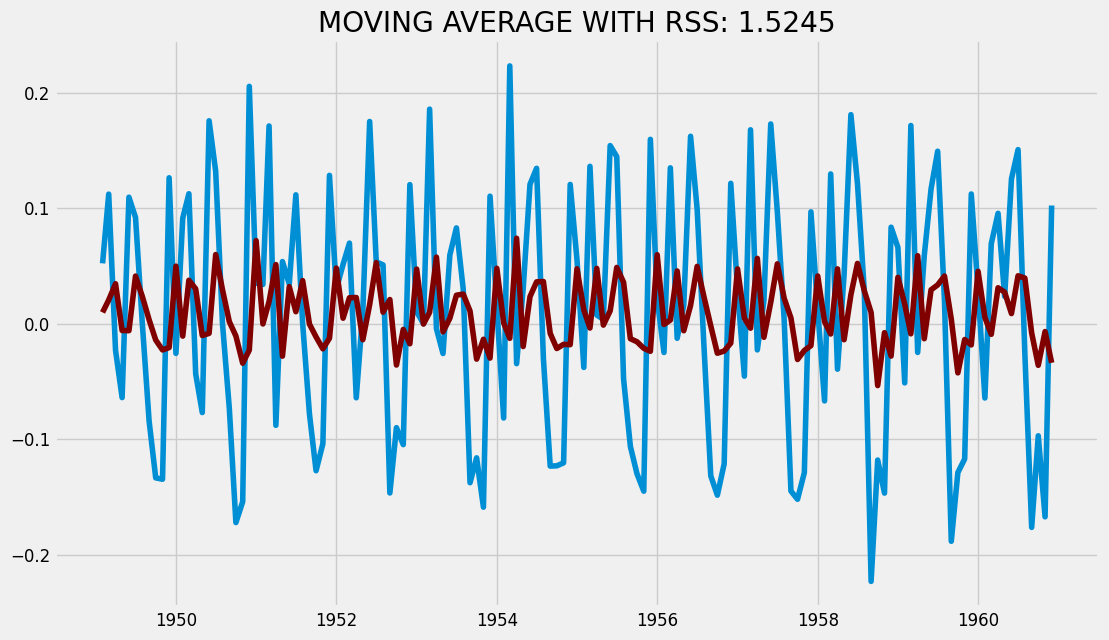

In [ ]:
plt.plot(ts_log_scale_diff)
plt.plot(model_fit.fittedvalues, color='maroon')
plt.title('MOVING AVERAGE WITH RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_scale_diff)**2))

## Autoregressive Integrated Moving Average (ARIMA)

In [ ]:
t_series = df2.passengers - df2.passengers.shift()
t_series.dropna(inplace=True)

##### ACF and PACF plots after differencing

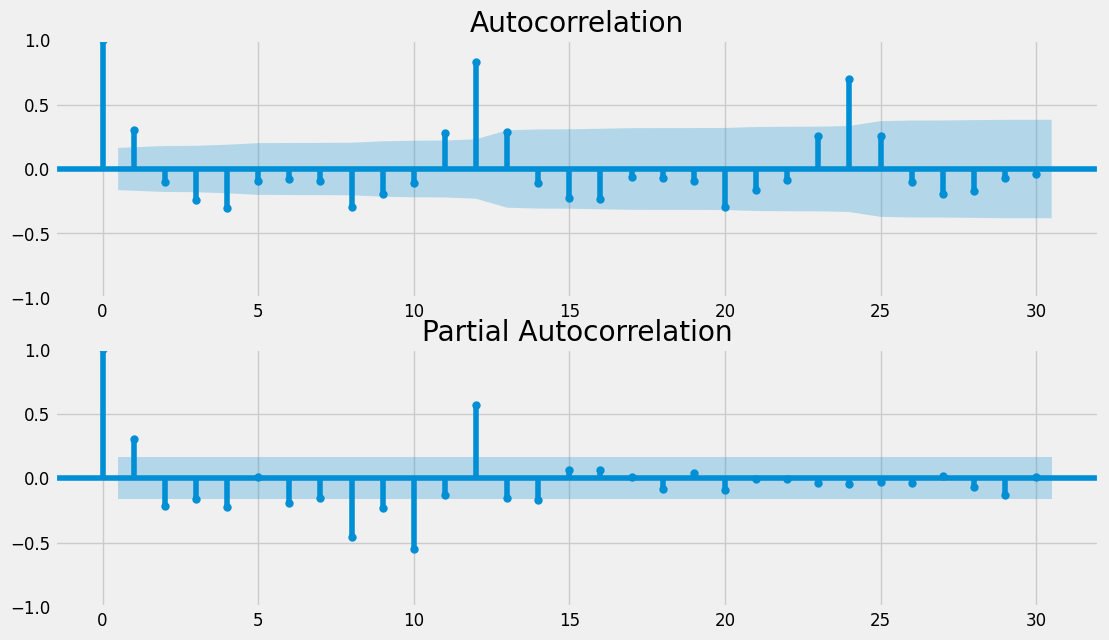

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(t_series, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(t_series, ax=plt.gca(),lags=30)
plt.show()

Text(0.5, 1.0, 'Train and Test Plot')

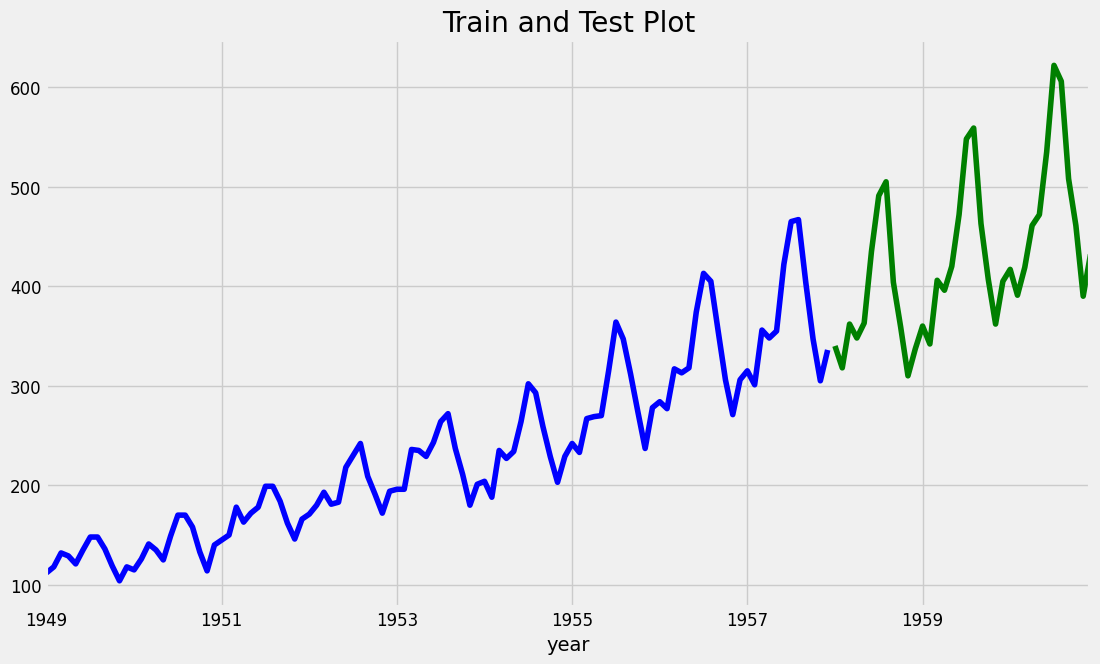

In [ ]:
#train and test set

train_set = df2[:int(0.75*(len(df2)))]
test_set = df2[int(0.75*(len(df2))):]

train_set['passengers'].plot(color='blue',label="train")
test_set['passengers'].plot(color='green',label="test")
plt.title("Train and Test Plot")


In [ ]:
# ARIMA model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Model fitting
arima_model = ARIMA(train_set, order=(1, 1, 1))
model_fit = arima_model.fit()

In [ ]:
start = test_set.index.min()
end = test_set.index.max()

# Predict
predictions = model_fit.predict(start=start, end=end)

In [ ]:
# metrics to evaluate performance
mse = mean_squared_error(df2[start:end], predictions)
rmse = sqrt(mse)
print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE: 12077.742153404317
RMSE: 109.89878140090688


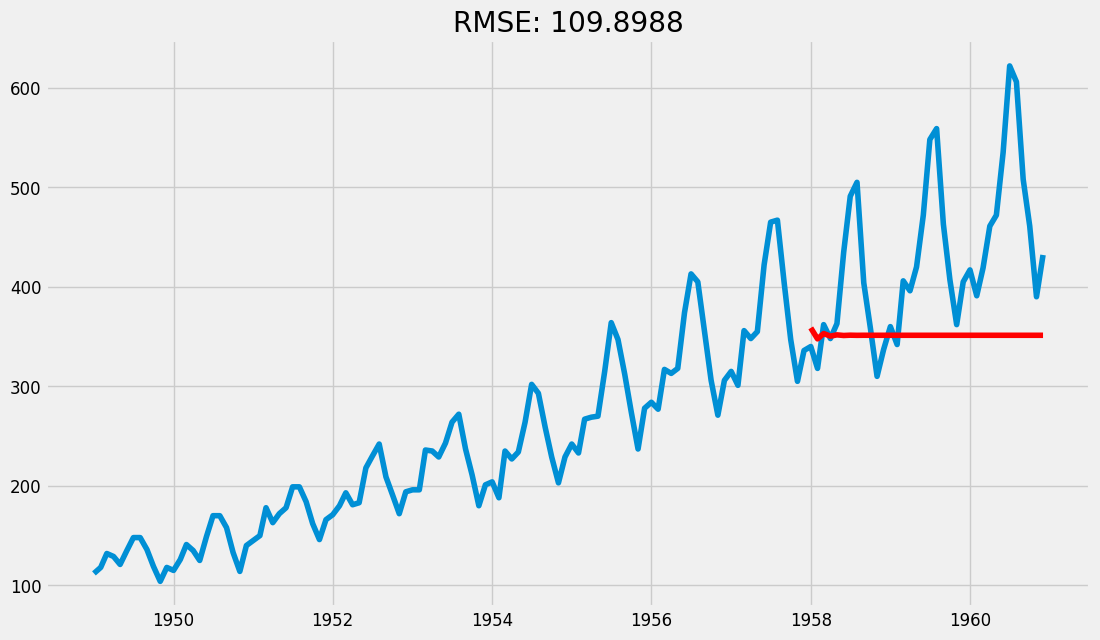

In [ ]:
plt.plot(df2.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [ ]:
predictions_ARIMA_diff_value= pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff_value.head())

# Calculating the cummulative sum
predictions_ARIMA_diff_cumsum_value = predictions_ARIMA_diff_value.cumsum()
print (predictions_ARIMA_diff_cumsum_value.head())

# Adding 1st month value back
predictions_ARIMA_log_scale = pd.Series(test_set.passengers.iloc[0], index=test_set.index)
predictions_ARIMA_log_scale = predictions_ARIMA_log_scale.add(predictions_ARIMA_diff_cumsum_value,fill_value=0)
predictions_ARIMA_log_scale.head()

1958-01-01    358.724115
1958-02-01    347.689827
1958-03-01    353.047814
1958-04-01    350.446104
1958-05-01    351.709432
Freq: MS, Name: predicted_mean, dtype: float64
1958-01-01     358.724115
1958-02-01     706.413943
1958-03-01    1059.461757
1958-04-01    1409.907860
1958-05-01    1761.617292
Freq: MS, Name: predicted_mean, dtype: float64


year
1958-01-01     698.724115
1958-02-01    1046.413943
1958-03-01    1399.461757
1958-04-01    1749.907860
1958-05-01    2101.617292
dtype: float64

Text(0.5, 1.0, 'RMSE: 3891.5007')

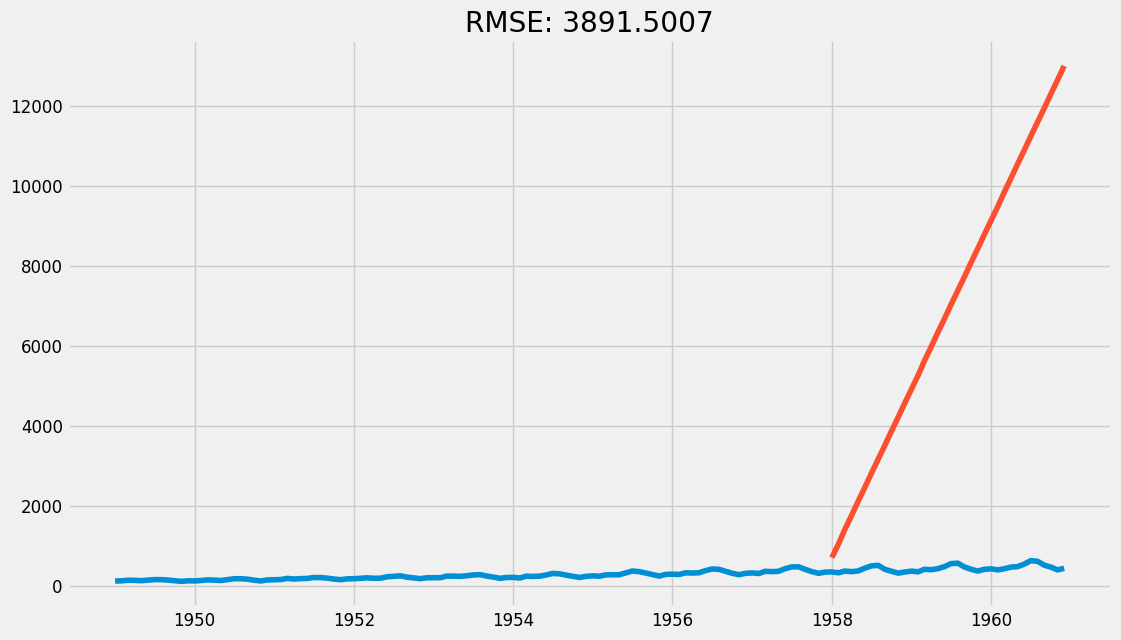

In [ ]:
plt.plot(df2.passengers)
plt.plot(predictions_ARIMA_log_scale)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log_scale-t_series)**2)/len(t_series)))

# Auto Arima

In [ ]:
#Model Fitting
from pmdarima import auto_arima
a_arima_model = auto_arima(train_set, trace=True, error_action='ignore', suppress_warnings=True, m=6, stepwise=True)
a_arima_model.fit(train_set)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=936.762, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1002.826, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=997.166, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=993.576, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1001.531, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=956.753, Time=0.73 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=959.218, Time=0.36 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=907.754, Time=1.00 sec
 ARIMA(1,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,1)(0,0,2)[6] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(3,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(2,1,3)(0,0,2)[6] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 6),
      suppress_warnings=True)

In [ ]:
start = test_set.index.min()
end = test_set.index.max()

#Predictions of validation data set
pred = a_arima_model.predict()

pred = a_arima_model.predict(n_periods=len(test_set))
pred = pd.DataFrame(pred,index = test_set.index,columns=['Prediction'])

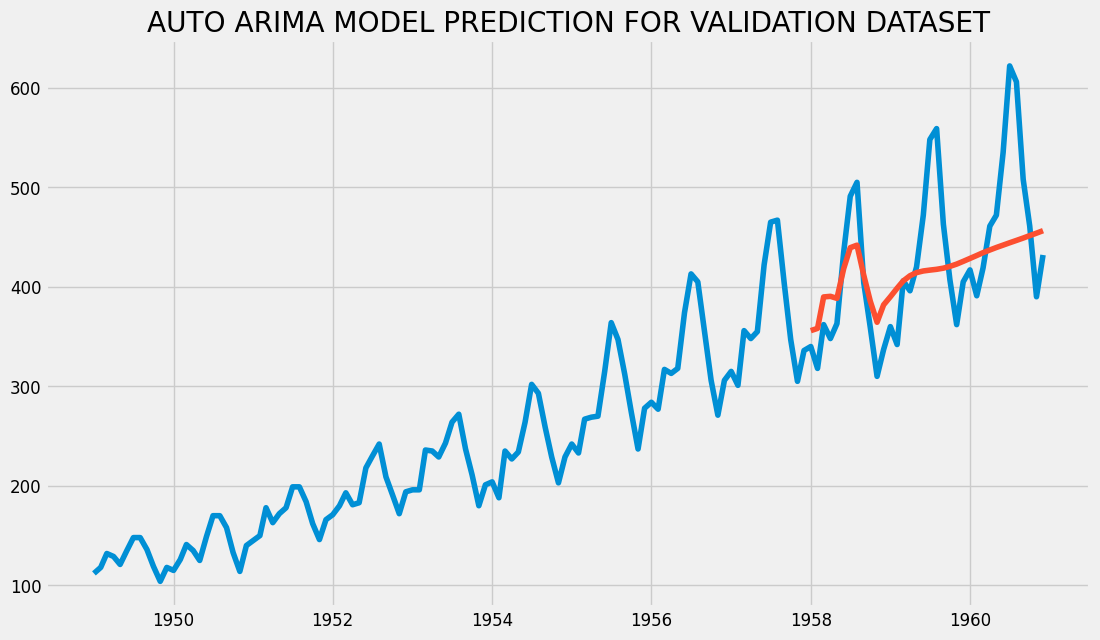

In [ ]:
predict = a_arima_model.predict(n_periods=len(test_set))
predict = pd.DataFrame(predict,index = test_set.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(df2.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(predict, label='Prediction')
plt.title("AUTO ARIMA MODEL PREDICTION FOR VALIDATION DATASET")
plt.show()

# SARIMA

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
sarima_model = SARIMAX(train_set, order=(3, 1, 3), seasonal_order=(1, 1, 1, 7))
sarima_model_fit = sarima_model.fit(disp=False)

In [ ]:
start = test_set.index.min()
end= test_set.index.max()

#Prediction using sarima model for validation set
predictions = sarima_model_fit.predict(start=start, end=end)

In [ ]:
# checking mse and rmse to evaluate performance
mse = mean_squared_error(df2[start:end], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 62.86900170431417, MSE:3952.5113752970583


Text(0.5, 1.0, 'SARIMA MODEL WITH RMSE: 62.8690')

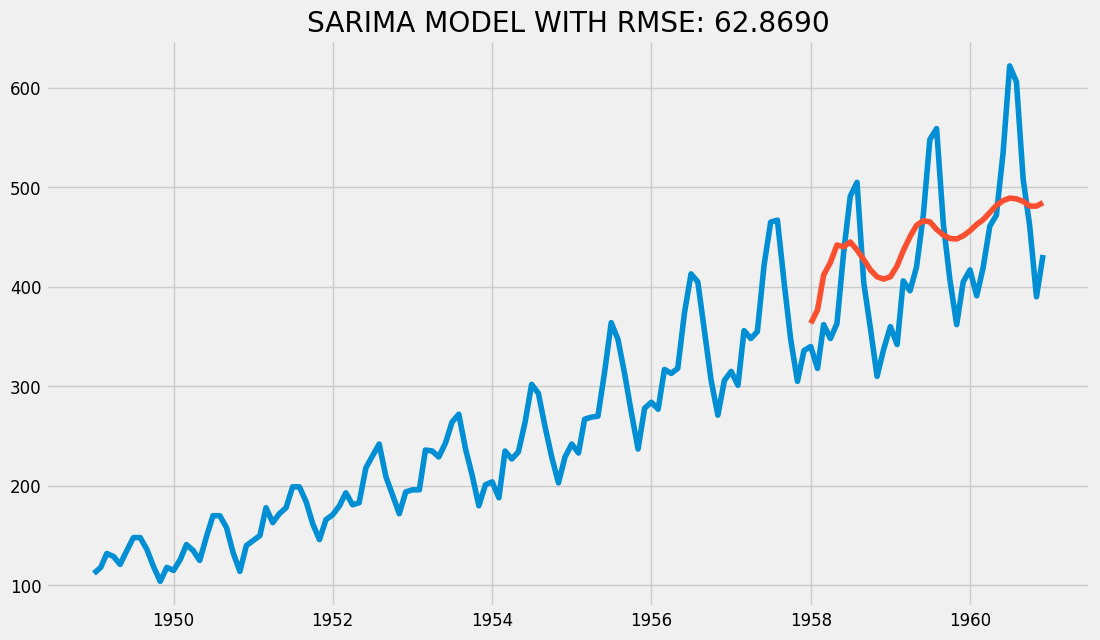

In [ ]:
plt.plot(df2)
plt.plot(predictions)
plt.title('SARIMA MODEL WITH RMSE: %.4f'% rmse)

# SARIMA

We are finding few possibilities for different p,d,q values with a range of 0 to 2 and applying them to the SARIMAX model to get better results.

In [ ]:
p = d = q = range(0, 2)
p_d_q = list(itertools.product(p, d, q))
seasonality_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

In [ ]:
min_aic = 999999999
for param in p_d_q:
    for i in seasonality_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_set,order=param,seasonal_order=i,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, i, results.aic))

            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070782
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.267707006777
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445503
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.095889541804
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602133
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006279
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113416
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.491212125711
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689458824
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569845619
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884756611585
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396780498
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.552024714264
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025319
ARIMA(0, 1, 0)x(0, 1, 0

In [ ]:
start = test_set.index.min()
end = test_set.index.max()

predict = min_aic_model.get_prediction(start=start,end=end, dynamic=False)

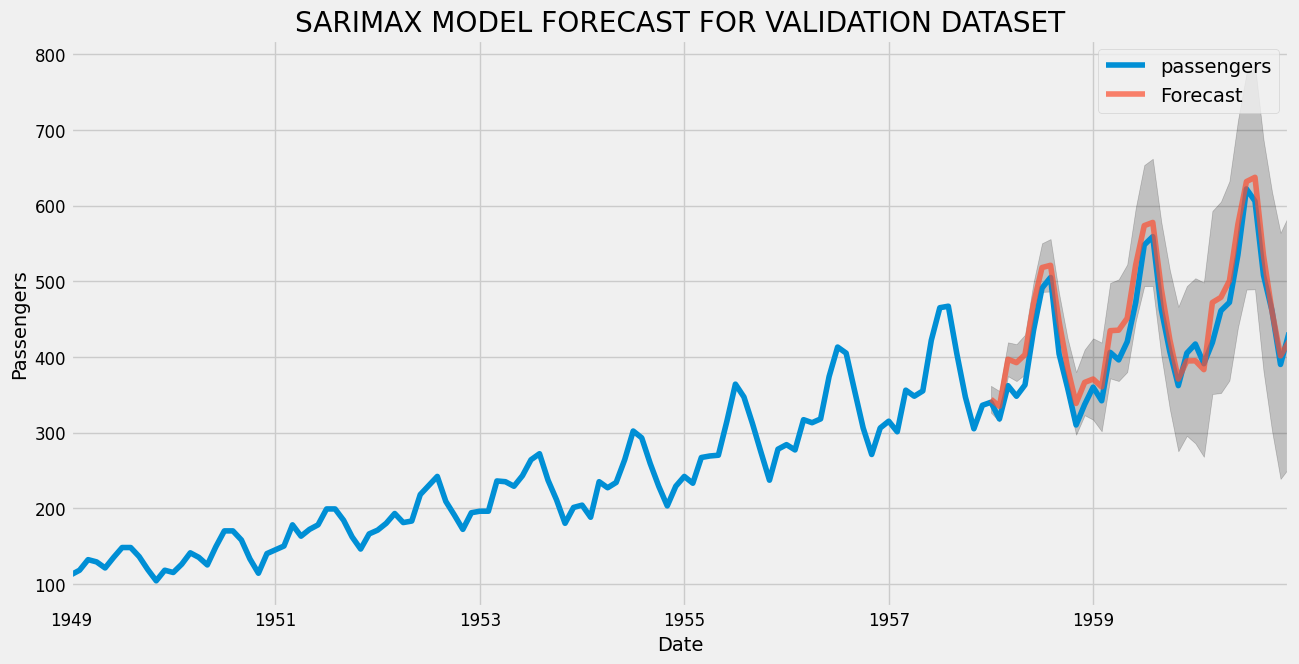

In [ ]:
predict_ci = predict.conf_int()
ax = df2['1949':].plot(label='observed')
predict.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(predict_ci.index,predict_ci.iloc[:, 0],predict_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.title("SARIMAX MODEL FORECAST FOR VALIDATION DATASET")
plt.show()

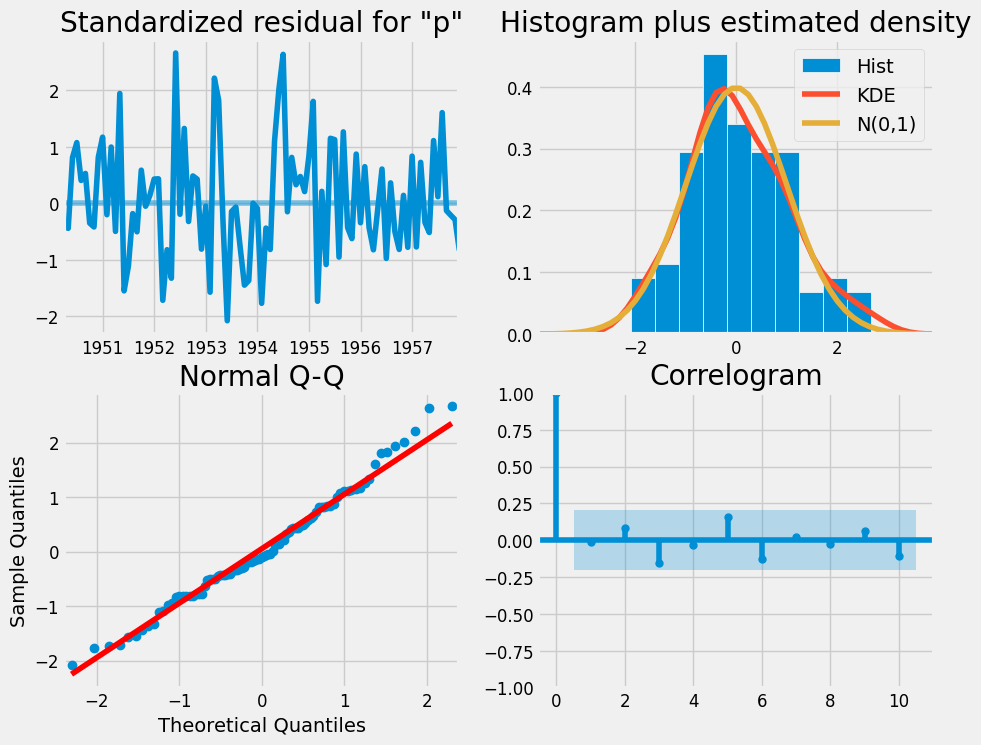

In [ ]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df2.to_csv("sarima_output.csv")